In [1]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from backend.autoencoders import Autoencoder, train_predict_autoencoder

warnings.filterwarnings("ignore")

# Data Loading

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load a DataFrame with a specific version of a CSV
df: pd.DataFrame = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shiveshprakash/34-year-daily-stock-data/versions/1",
    "stock_data.csv",
)

# Drop useless columns or which we will create ourselves
df = df.drop(columns=["prev_day"])

# Display the first few rows of the dataframe
df.head()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669


# Data Cleaning and Preprocessing

In [3]:
# Check for missing values
df.isnull().sum()

dt              0
vix             0
sp500           0
sp500_volume    0
djia            0
djia_volume     0
hsi             0
ads             0
us3m            0
joblessness     0
epu             0
GPRD            0
dtype: int64

In [4]:
# Convert "dt" to datetime format
df["dt"] = pd.to_datetime(df["dt"], format="%Y-%m-%d")

# Check data types
df.dtypes

dt              datetime64[ns]
vix                    float64
sp500                  float64
sp500_volume           float64
djia                   float64
djia_volume            float64
hsi                    float64
ads                    float64
us3m                   float64
joblessness              int64
epu                    float64
GPRD                   float64
dtype: object

# Data Analysis

### General Plots

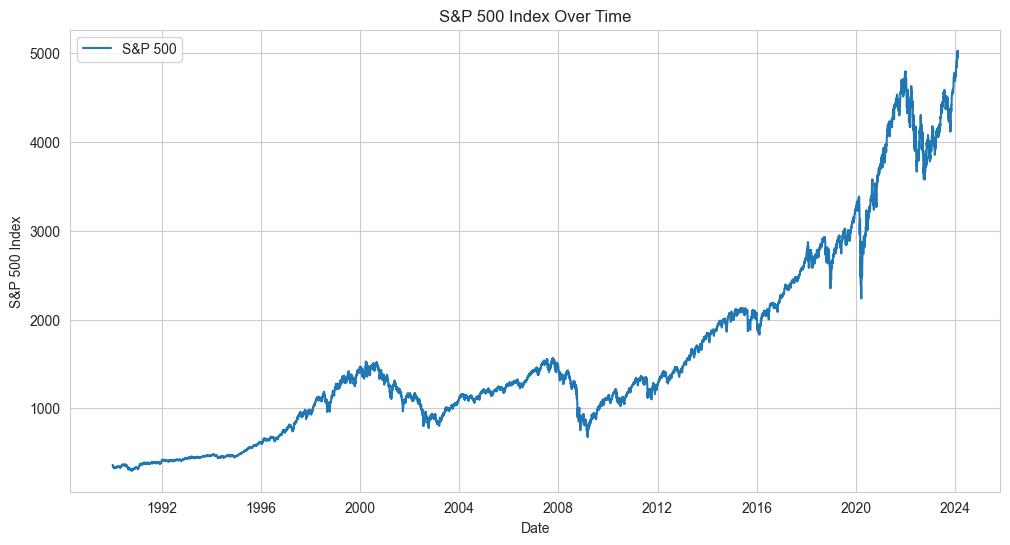

In [5]:
# Plot the S&P 500 over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["dt"], y=df["sp500"], label="S&P 500")
plt.title("S&P 500 Index Over Time")
plt.xlabel("Date")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

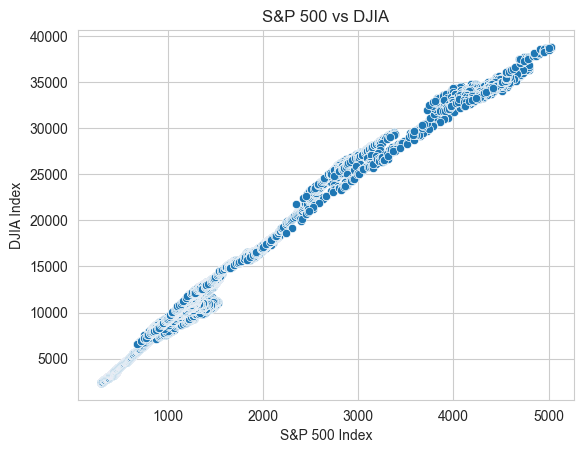

In [6]:
# Visualize the relationship between S&P 500 and DJIA
sns.scatterplot(x="sp500", y="djia", data=df)
plt.title("S&P 500 vs DJIA")
plt.xlabel("S&P 500 Index")
plt.ylabel("DJIA Index")
plt.show()

### Correlation Analysis

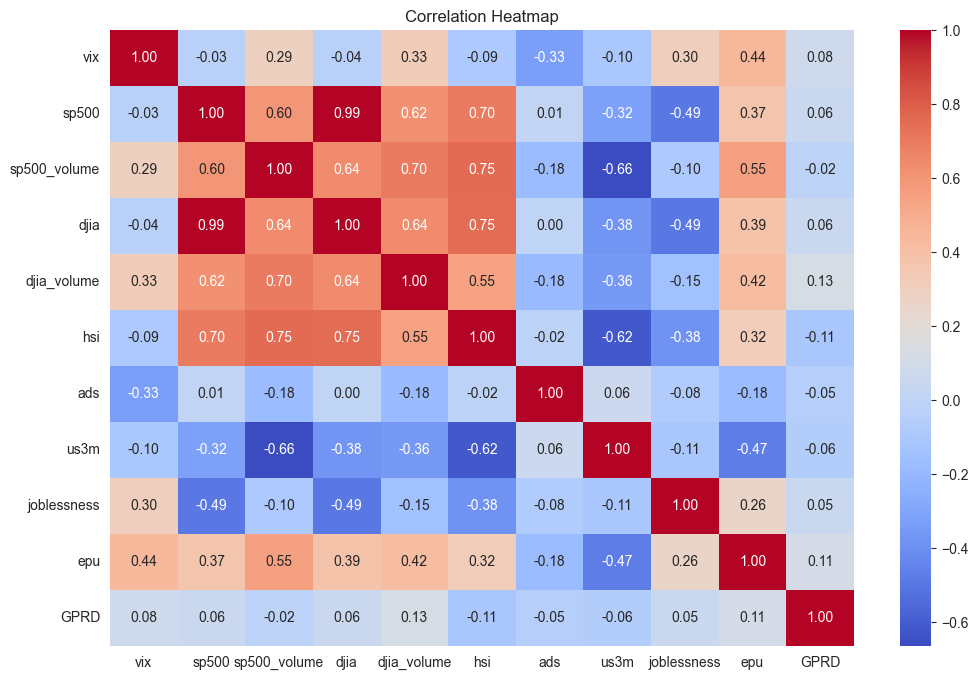

In [7]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Create new features

### Aggregate Rolling Features

In [8]:
windows = [7, 14, 30, 90, 365]  # Rolling window sizes (days)

for window in windows:
    df[f"sp500_mean_{window}"] = df["sp500"].rolling(window=window).mean()
    df[f"sp500_std_{window}"] = df["sp500"].rolling(window=window).std()
    df[f"sp500_volume_mean_{window}"] = df["sp500_volume"].rolling(window=window).mean()
    df[f"sp500_volume_std_{window}"] = df["sp500_volume"].rolling(window=window).std()

    df[f"djia_mean_{window}"] = df["djia"].rolling(window=window).mean()
    df[f"djia_std_{window}"] = df["djia"].rolling(window=window).std()
    df[f"djia_volume_mean_{window}"] = df["djia_volume"].rolling(window=window).mean()
    df[f"djia_volume_std_{window}"] = df["djia_volume"].rolling(window=window).std()

    df[f"hsi_mean_{window}"] = df["hsi"].rolling(window=window).mean()
    df[f"hsi_std_{window}"] = df["hsi"].rolling(window=window).std()

    df[f"vix_mean_{window}"] = df["vix"].rolling(window=window).mean()
    df[f"vix_std_{window}"] = df["vix"].rolling(window=window).std()

# Drop rows with NaN values introduced by rolling calculations
df = df.dropna()

# Display the updated DataFrame
df.head()

,dt,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,sp500_volume_mean_365,sp500_volume_std_365,djia_mean_365,djia_std_365,djia_volume_mean_365,djia_volume_std_365,hsi_mean_365,hsi_std_365,vix_mean_365,vix_std_365
364,1991-06-12,17.72,376.649994,166140000.0,2961.99,18.59,3627.0,0.346196,5.73,4,...,1.657622e+08,3.732704e+07,2733.066575,167.956021,20.924329,8.009330,3185.880001,313.099613,22.138055,4.914542
365,1991-06-13,16.99,377.630005,145650000.0,2965.12,17.02,3632.0,0.338650,5.76,4,...,1.656343e+08,3.731573e+07,2733.492301,168.347358,20.906247,8.010678,3187.998631,313.495691,22.134767,4.917591
366,1991-06-14,15.98,382.290009,167950000.0,3000.45,21.24,3639.0,0.330614,5.77,4,...,1.656095e+08,3.731116e+07,2734.052219,168.895068,20.897671,8.008635,3190.110960,313.930813,22.125890,4.925785
367,1991-06-17,15.50,380.130005,134230000.0,2993.96,15.95,3639.0,0.303792,5.78,4,...,1.655429e+08,3.734549e+07,2734.656904,169.430041,20.885781,8.012760,3192.300275,314.268007,22.113260,4.936865
368,1991-06-18,16.14,378.589996,155200000.0,2986.81,19.14,3639.0,0.294269,5.80,4,...,1.655842e+08,3.732561e+07,2735.184137,169.915090,20.892712,8.010145,3194.555069,314.513043,22.101973,4.945816


### Autoencoders

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Create lagged features (temporary DataFrame)
lag_days = 365
lagged_df = pd.DataFrame()
for lag in range(1, lag_days + 1):
    lagged_df[f"sp500_lag_{lag}"] = df["sp500"].shift(lag)
    lagged_df[f"vix_lag_{lag}"] = df["vix"].shift(lag)
    lagged_df[f"sp500_volume_lag_{lag}"] = df["sp500_volume"].shift(lag)

# Drop rows with NaN values
lagged_df = lagged_df.dropna()
df = df.iloc[lag_days:].reset_index(drop=True)

# Normalize lagged features
scaler = MinMaxScaler()
X_lagged = scaler.fit_transform(lagged_df.values)
joblib.dump(scaler, "lagged_scaler.pkl")  # Save the scaler

# Clean up: Delete the temporary lagged features DataFrame
del lagged_df

# Get input dimensions
input_dim = X_lagged.shape[1]  # Number of lagged features

# Display the number of lagged features
print(f"Nr of lagged features: {input_dim}")

Nr of lagged features: 1095


In [10]:
# Initialize the Autoencoder
encoding_dim = 10  # Compressed representation size
autoencoder = Autoencoder(input_dim, encoding_dim)

# Train the autoencoder and get embeddings
trained_autoencoder, embeddings = train_predict_autoencoder(
    autoencoder,
    X_lagged,
    epochs=100,
    batch_size=256,
    lr=0.0005,
    l1_penalty=0.001,
    weight_decay=1e-5
)

Epoch 1/100, Avg Loss: 0.0745
Epoch 2/100, Avg Loss: 0.0288
Epoch 3/100, Avg Loss: 0.0256
Epoch 4/100, Avg Loss: 0.0301
Epoch 5/100, Avg Loss: 0.0353
Epoch 6/100, Avg Loss: 0.0280
Epoch 7/100, Avg Loss: 0.0246
Epoch 8/100, Avg Loss: 0.0216
Epoch 9/100, Avg Loss: 0.0202
Epoch 10/100, Avg Loss: 0.0196
Epoch 11/100, Avg Loss: 0.0199
Epoch 12/100, Avg Loss: 0.0185
Epoch 13/100, Avg Loss: 0.0173
Epoch 14/100, Avg Loss: 0.0178
Epoch 15/100, Avg Loss: 0.0171
Epoch 16/100, Avg Loss: 0.0179
Epoch 17/100, Avg Loss: 0.0180
Epoch 18/100, Avg Loss: 0.0191
Epoch 19/100, Avg Loss: 0.0224
Epoch 20/100, Avg Loss: 0.0179
Epoch 21/100, Avg Loss: 0.0175
Epoch 22/100, Avg Loss: 0.0197
Epoch 23/100, Avg Loss: 0.0173
Epoch 24/100, Avg Loss: 0.0166
Epoch 25/100, Avg Loss: 0.0171
Epoch 26/100, Avg Loss: 0.0178
Epoch 27/100, Avg Loss: 0.0168
Epoch 28/100, Avg Loss: 0.0153
Epoch 29/100, Avg Loss: 0.0146
Epoch 30/100, Avg Loss: 0.0158
Epoch 31/100, Avg Loss: 0.0147
Epoch 32/100, Avg Loss: 0.0152
Epoch 33/100, Avg

In [11]:
# Convert embeddings to DataFrame
embedding_df = pd.DataFrame(embeddings, columns=[f"embed_{i + 1}" for i in range(embeddings.shape[1])])

### Prepare the final df to train

##### Take the right data for training

In [12]:
# Select only numeric columns for training
training_df = df.select_dtypes(include=[np.number])

# Convert to an ordered categorical column
if training_df["joblessness"].dtypes != "category":
    training_df["joblessness"] = pd.Categorical(
        training_df["joblessness"],
        categories=[1, 2, 3, 4],
        ordered=True
    )

##### Scale the df

In [13]:
# Separate the "joblessness" column
joblessness = training_df["joblessness"]

# Select all columns except "joblessness"
columns_to_scale = training_df.drop(columns=["joblessness"]).columns

# Apply MinMaxScaler to the selected columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(training_df[columns_to_scale])
joblib.dump(scaler, "training_df_scaler.pkl")  # Save the scaler

# Create a DataFrame for the scaled data
training_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=training_df.index)

# Add back the "joblessness" column
training_df["joblessness"] = joblessness

##### Attach embeddings to the training DataFrame

In [14]:
# Attach embeddings to the main DataFrame
training_df = pd.concat([training_df.reset_index(drop=True), embedding_df], axis=1)

# Display the final DataFrame with embeddings
training_df.head()

,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,epu,GPRD,...,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10
0,0.073555,0.000000,0.017838,0.000000,0.023505,0.030881,0.745587,0.501558,0.209967,0.072191,...,0.007963,-0.004384,-0.017109,0.006171,-0.006669,-0.007552,-0.014003,-0.012592,-0.006377,-0.002507
1,0.070564,0.000165,0.017807,0.000061,0.021713,0.031133,0.746132,0.501558,0.209967,0.077164,...,0.007963,-0.004384,-0.017109,0.006171,-0.006669,-0.007552,-0.014003,-0.012592,-0.006377,-0.002507
2,0.061591,0.000825,0.021193,0.000562,0.035881,0.031942,0.746698,0.510903,0.209967,0.069603,...,0.007963,-0.004384,-0.017109,0.006171,-0.006669,-0.007552,-0.014003,-0.012592,-0.006377,-0.002507
3,0.057920,0.000493,0.015518,0.000440,0.023961,0.032538,0.748524,0.520249,0.209967,0.134422,...,0.007963,-0.004384,-0.017109,0.006171,-0.006669,-0.007552,-0.014003,-0.012592,-0.006377,-0.002507
4,0.047859,0.001029,0.019801,0.001161,0.028749,0.035289,0.749184,0.512461,0.209967,0.103475,...,0.007963,-0.004384,-0.017109,0.006171,-0.006669,-0.007552,-0.014003,-0.012592,-0.006377,-0.002507


In [15]:
print(list(training_df.columns))

['vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi', 'ads', 'us3m', 'epu', 'GPRD', 'sp500_mean_7', 'sp500_std_7', 'sp500_volume_mean_7', 'sp500_volume_std_7', 'djia_mean_7', 'djia_std_7', 'djia_volume_mean_7', 'djia_volume_std_7', 'hsi_mean_7', 'hsi_std_7', 'vix_mean_7', 'vix_std_7', 'sp500_mean_14', 'sp500_std_14', 'sp500_volume_mean_14', 'sp500_volume_std_14', 'djia_mean_14', 'djia_std_14', 'djia_volume_mean_14', 'djia_volume_std_14', 'hsi_mean_14', 'hsi_std_14', 'vix_mean_14', 'vix_std_14', 'sp500_mean_30', 'sp500_std_30', 'sp500_volume_mean_30', 'sp500_volume_std_30', 'djia_mean_30', 'djia_std_30', 'djia_volume_mean_30', 'djia_volume_std_30', 'hsi_mean_30', 'hsi_std_30', 'vix_mean_30', 'vix_std_30', 'sp500_mean_90', 'sp500_std_90', 'sp500_volume_mean_90', 'sp500_volume_std_90', 'djia_mean_90', 'djia_std_90', 'djia_volume_mean_90', 'djia_volume_std_90', 'hsi_mean_90', 'hsi_std_90', 'vix_mean_90', 'vix_std_90', 'sp500_mean_365', 'sp500_std_365', 'sp500_volume_mean_365', 'sp

# Train the models

In [16]:
from backend.models import train_model, evaluate_model, plot_predictions, prepare_data, objective
import optuna

# Define the prediction horizons
days_to_predict = [1, 7, 14, 21, 28]

In [17]:
# Prepare data
X_train, X_test, y_train, y_test = prepare_data(training_df, days_to_predict)

In [18]:
# Number of trials for optimization
n_trials = 50  # Increase for better results

# Enable Bayesian Optimization & Pruner
study_lgbm = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study_lgbm.optimize(lambda trial: objective(trial, "LightGBM", X_train, y_train, X_test, y_test), n_trials=n_trials)

study_xgb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study_xgb.optimize(lambda trial: objective(trial, "XGBoost", X_train, y_train, X_test, y_test), n_trials=n_trials)

# Print the best hyperparameters
print("\nBest LightGBM Parameters:")
print(study_lgbm.best_params)

print("\nBest XGBoost Parameters:")
print(study_xgb.best_params)

[I 2025-02-01 14:30:27,541] A new study created in memory with name: no-name-47e490a3-2cb9-475d-9c5f-3caf22c140c5
[I 2025-02-01 14:30:28,640] Trial 0 finished with value: 0.08557889723319953 and parameters: {'learning_rate': 0.036167278549626966, 'max_depth': 8, 'num_leaves': 67, 'min_child_samples': 29, 'colsample_bytree': 0.9317731519773979, 'subsample': 0.9589989705672727, 'reg_lambda': 0.00016063803555539343, 'reg_alpha': 0.003735463324503566}. Best is trial 0 with value: 0.08557889723319953.
[I 2025-02-01 14:30:29,217] Trial 1 finished with value: 0.08407148424247803 and parameters: {'learning_rate': 0.010052353809486879, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 28, 'colsample_bytree': 0.7407551091876573, 'subsample': 0.9074608040546728, 'reg_lambda': 0.021623700449396273, 'reg_alpha': 0.030382766313186666}. Best is trial 1 with value: 0.08407148424247803.
[I 2025-02-01 14:30:30,258] Trial 2 finished with value: 0.08559399124532227 and parameters: {'learning_rate': 0


Best LightGBM Parameters:
{'learning_rate': 0.033770721354303354, 'max_depth': 8, 'num_leaves': 122, 'min_child_samples': 18, 'colsample_bytree': 0.8750388873923902, 'subsample': 0.5462209306286405, 'reg_lambda': 0.0027449893922279938, 'reg_alpha': 0.099205687687718}

Best XGBoost Parameters:
{'learning_rate': 0.08466886296991476, 'max_depth': 3, 'min_child_weight': 15, 'colsample_bytree': 0.8631387702884468, 'subsample': 0.5957258848835755, 'gamma': 0.00024709982607730023, 'reg_lambda': 0.0017381484249868737, 'reg_alpha': 0.018760199863828566}


In [20]:
# Use best parameters from Optuna
best_lgbm_params = study_lgbm.best_params
best_xgb_params = study_xgb.best_params

# Train with best parameters
models = {
    "LinearRegression": {},
    "LightGBM": best_lgbm_params,
    "XGBoost": best_xgb_params
}

all_results = {}
for model_name, params in models.items():
    print(f"\nTraining {model_name} with Optimized Parameters...\n" + "=" * 50)

    # Train model
    model, y_pred = train_model(model_name, X_train, y_train, X_test, **params)

    # Evaluate model
    results = evaluate_model(model_name, y_test, y_pred, days_to_predict)

    # Store results
    all_results[model_name] = results

    # Plot predictions
    plot_predictions(y_test, y_pred, days_to_predict, results, model_name)


==== Training Models for Day 1 Prediction ====


Training LinearRegression for Day 1...


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Conclusion and Future Work
...